<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/ReviewTokoBaju_RNN_LSTM_GRU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Deep Learning RNN

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Deep Learning/ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Text preprocessing
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['Review Text']).toarray()
X = pad_sequences(X, maxlen=300, padding='post')  # Ensure equal length

y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train, x_test = torch.tensor(x_train, dtype=torch.long), torch.tensor(x_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [3]:
# Dataset
class ReviewDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = ReviewDataset(x_train, y_train)
test_dataset = ReviewDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# Model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out

In [5]:
# Model setup
model = RNNModel(vocab_size=5000, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(10):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/10] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")

Epoch [1/10] Train Acc: 0.8168, Train Loss: 0.4819 | Test Acc: 0.8207, Test Loss: 0.4706
Epoch [2/10] Train Acc: 0.8184, Train Loss: 0.4790 | Test Acc: 0.8207, Test Loss: 0.4724
Epoch [3/10] Train Acc: 0.8184, Train Loss: 0.4781 | Test Acc: 0.8207, Test Loss: 0.4711
Epoch [4/10] Train Acc: 0.8184, Train Loss: 0.4777 | Test Acc: 0.8207, Test Loss: 0.4738
Epoch [5/10] Train Acc: 0.8184, Train Loss: 0.4784 | Test Acc: 0.8207, Test Loss: 0.4833
Epoch [6/10] Train Acc: 0.8184, Train Loss: 0.4790 | Test Acc: 0.8207, Test Loss: 0.4711
Epoch [7/10] Train Acc: 0.8184, Train Loss: 0.4773 | Test Acc: 0.8207, Test Loss: 0.4737
Epoch [8/10] Train Acc: 0.8184, Train Loss: 0.4771 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [9/10] Train Acc: 0.8184, Train Loss: 0.4771 | Test Acc: 0.8207, Test Loss: 0.4706
Epoch [10/10] Train Acc: 0.8184, Train Loss: 0.4766 | Test Acc: 0.8207, Test Loss: 0.4716


Final Training Accuracy: 0.8184
Final Testing Accuracy: 0.8207
Precision: 0.8207
Recall: 1.0000
F1 Squared: 0.8128
AUC: 0.5064


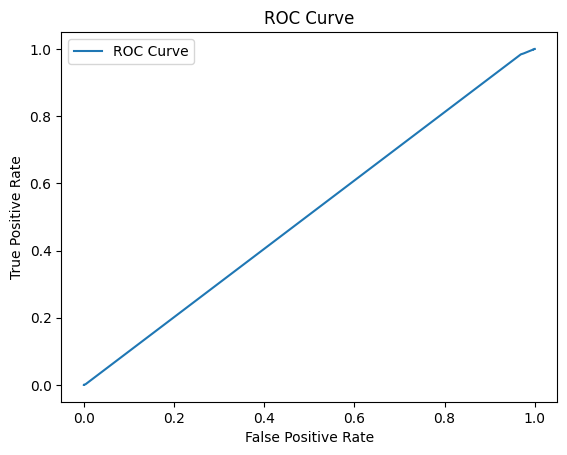

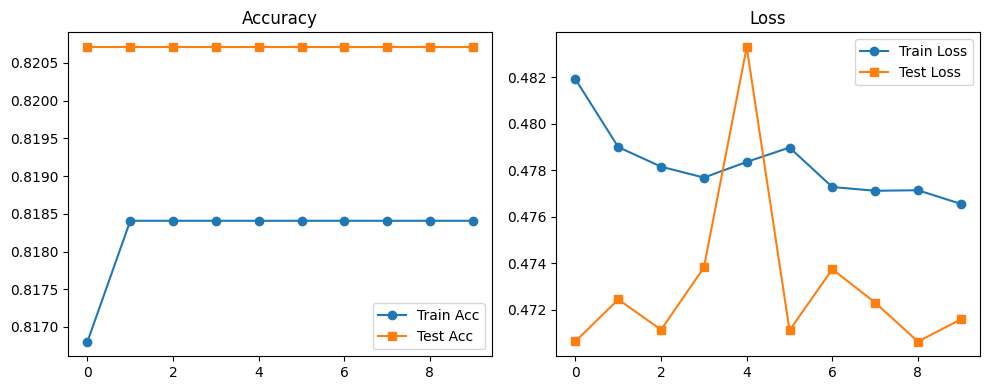

In [6]:
# Final Evaluation
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='o')
plt.plot(test_acc_list, label="Test Acc", marker='s')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(test_loss_list, label="Test Loss", marker='s')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

#Model Deep Learning LSTM

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Deep Learning/ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Review Text'])
X = tokenizer.texts_to_sequences(df['Review Text'])
X = pad_sequences(X, maxlen=300, padding='post')
y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Device: cuda


In [26]:
# Convert ke tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Buat Dataset & DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
# Definisi Model LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, (h_n, _) = self.lstm(embedded)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)  # Gabung dua arah
        x = self.dropout(torch.relu(self.fc1(h_n)))
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

# Inisialisasi model
vocab_size = len(tokenizer.word_index) + 1
model = SentimentLSTM(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)

# Loss dan Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Training
epochs = 10
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    # Validasi
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = (outputs >= 0.5).float()
            val_correct += (preds == y_batch).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_loss_hist.append(val_loss / len(test_loader))
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Acc: 0.8271, Val Acc: 0.8525
Epoch 2/10 | Train Acc: 0.8606, Val Acc: 0.8340
Epoch 3/10 | Train Acc: 0.8881, Val Acc: 0.8819
Epoch 4/10 | Train Acc: 0.8991, Val Acc: 0.8691
Epoch 5/10 | Train Acc: 0.9196, Val Acc: 0.8854
Epoch 6/10 | Train Acc: 0.9363, Val Acc: 0.8821
Epoch 7/10 | Train Acc: 0.9540, Val Acc: 0.8907
Epoch 8/10 | Train Acc: 0.9631, Val Acc: 0.8907
Epoch 9/10 | Train Acc: 0.9761, Val Acc: 0.8881
Epoch 10/10 | Train Acc: 0.9807, Val Acc: 0.8843


In [29]:
# Evaluasi akhir
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

# Hitung metrik
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"LSTM Results:")
print(f"Final Training Accuracy: {train_acc_hist[-1]:.4f}")
print(f"Final Testing Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

LSTM Results:
Final Training Accuracy: 0.9807
Final Testing Accuracy: 0.8843
Precision: 0.9263
Recall: 0.9333
F1 Squared: 0.8645
AUC: 0.9139


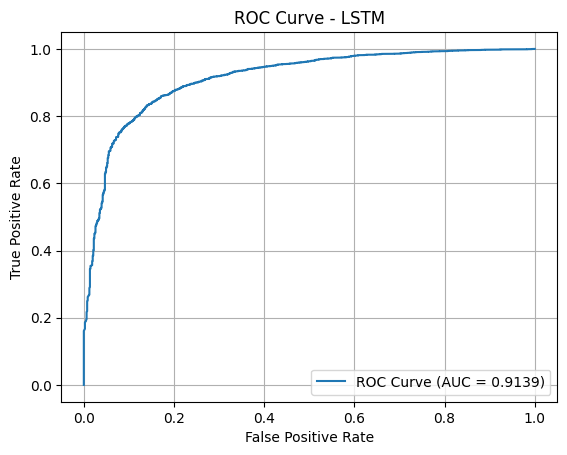

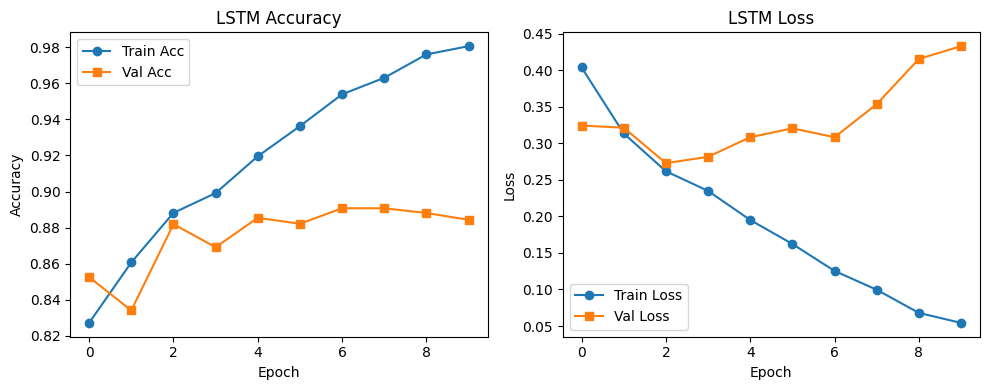

In [30]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy & Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', marker='o')
plt.plot(val_acc_hist, label='Val Acc', marker='s')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', marker='o')
plt.plot(val_loss_hist, label='Val Loss', marker='s')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Model Deep Learning GRU

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Deep Learning/ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Review Text'])
X = tokenizer.texts_to_sequences(df['Review Text'])
X = pad_sequences(X, maxlen=300, padding='post')
y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Device: cuda


In [33]:
# Convert ke tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Buat Dataset & DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
# Definisi Model GRU
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, h_n = self.gru(embedded)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)  # Gabung dua arah
        x = self.dropout(torch.relu(self.fc1(h_n)))
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

# Inisialisasi model
vocab_size = len(tokenizer.word_index) + 1
model = SentimentGRU(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)

# Loss dan Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
# Training
epochs = 10
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    # Validasi
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = (outputs >= 0.5).float()
            val_correct += (preds == y_batch).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_loss_hist.append(val_loss / len(test_loader))
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Acc: 0.8396, Val Acc: 0.8518
Epoch 2/10 | Train Acc: 0.8848, Val Acc: 0.8892
Epoch 3/10 | Train Acc: 0.9138, Val Acc: 0.8755
Epoch 4/10 | Train Acc: 0.9361, Val Acc: 0.8942
Epoch 5/10 | Train Acc: 0.9568, Val Acc: 0.8900
Epoch 6/10 | Train Acc: 0.9701, Val Acc: 0.8881
Epoch 7/10 | Train Acc: 0.9791, Val Acc: 0.8865
Epoch 8/10 | Train Acc: 0.9855, Val Acc: 0.8898
Epoch 9/10 | Train Acc: 0.9925, Val Acc: 0.8925
Epoch 10/10 | Train Acc: 0.9935, Val Acc: 0.8878


In [36]:
# Evaluasi akhir
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

# Hitung metrik
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"GRU Results:")
print(f"Final Training Accuracy: {train_acc_hist[-1]:.4f}")
print(f"Final Testing Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

GRU Results:
Final Training Accuracy: 0.9935
Final Testing Accuracy: 0.8878
Precision: 0.9359
Recall: 0.9268
F1 Squared: 0.8674
AUC: 0.9155


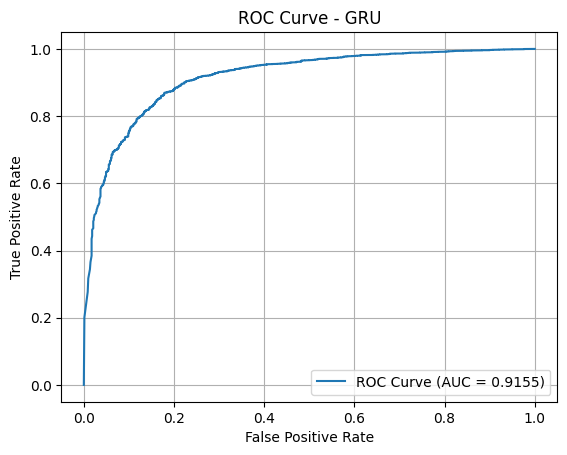

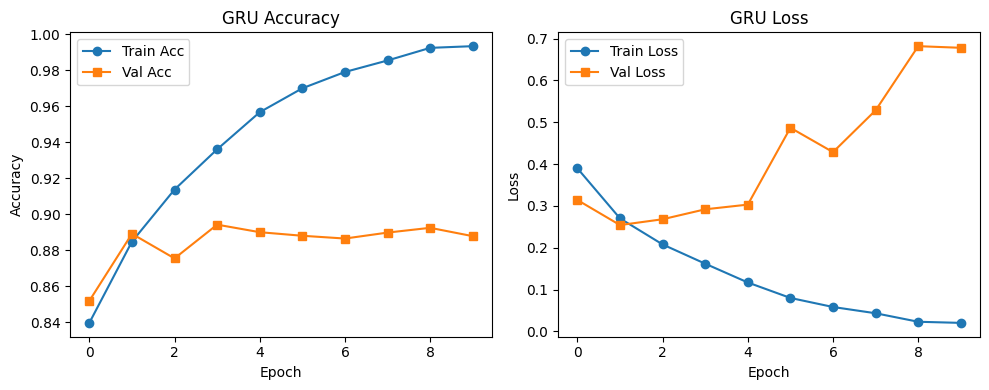

In [37]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy & Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', marker='o')
plt.plot(val_acc_hist, label='Val Acc', marker='s')
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', marker='o')
plt.plot(val_loss_hist, label='Val Loss', marker='s')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 📊 Persamaan Matematika Evaluasi Model Klasifikasi

- **TP** = True Positive  
- **TN** = True Negative  
- **FP** = False Positive  
- **FN** = False Negative  

---

### ✅ 1. Accuracy (Akurasi)  
Mengukur seberapa sering prediksi model benar:

\[$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$\]

---

### 🎯 2. Precision (Presisi)  
Mengukur berapa banyak dari yang diprediksi positif ternyata benar-benar positif:

\[$
\text{Precision} = \frac{TP}{TP + FP}
$\]

---

### 🔍 3. Recall (Sensitivitas / True Positive Rate)  
Mengukur seberapa banyak dari total positif yang berhasil ditemukan model:

\[$
\text{Recall} = \frac{TP}{TP + FN}
$\]

---

### ⚖️ 4. F1 Score  
Rata-rata harmonis dari Precision dan Recall:

\[$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$\]

Jika ingin menghitung **F1-Squared**:

\[$
\text{F1}^2 = (\text{F1})^2
$\]

---

### 📈 5. AUC (Area Under Curve ROC)  
Luas di bawah kurva ROC, di mana:

- Sumbu X: False Positive Rate (FPR)
- Sumbu Y: True Positive Rate (TPR / Recall)

\[$
\text{FPR} = \frac{FP}{FP + TN}
$\]

\[$
\text{TPR} = \frac{TP}{TP + FN}
$\]

AUC dihitung dari integrasi numerik grafik ROC Curve.

---